In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_runner
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dataclasses
import pandas as pd
import statsmodels.api as sm
import ISLP
import ISLP.models
import subprocess
import io

predict_all = True

MainProcess


In [2]:
# Prepare datasets
if predict_all:
     res_dir = fls.result_dir + '/many_abbr_full/'
#     fls.download_kaggle_dataset('jeroencottaar/byu-many-models/', res_dir)
else:
     res_dir = fls.result_dir + '/many_abbr_res/'
     fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated/', res_dir)

In [3]:
# Read results from vast.ai
files = glob.glob(res_dir + '*.pickle')
dicts = []
dicts_kaggle_comp = []
for f in files:    
    print(f)
    data = fls.dill_load(f)    
    d = data.modifier_values
    
    if not (d['seed']>=5): print('skip'); continue

    if predict_all:
        data.trained_model.data_after_step2 = data.inferred_test_data     
        data.trained_model.step3Output.threshold=-1
        data.inferred_test_data = data.trained_model.infer(data.test_data)
        
    d['label'] = data.label
    d['git_commit_id'] = data.git_commit_id
    d['use_missing_value'] = data.use_missing_value
    d['cv_score'] = fls.score_competition_metric(data.inferred_test_data, data.test_data)[2]

    d_kaggle_comp = dict()
    d_kaggle_comp['label'] = data.label
    d_kaggle_comp['git_commit_id'] = d['git_commit_id']
    d_kaggle_comp['use_missing_value'] = d['use_missing_value']
    d_kaggle_comp['seed'] = d['seed']   
    d_kaggle_comp['cv_score'] = d['cv_score']
    d_kaggle_comp['k_score'] = np.nan

    dicts_kaggle_comp.append(d_kaggle_comp)

    # First set
    #if not (d['seed']<26 or d['use_missing_value']): print('skip'); continue

    # New
    #if not (d['seed']>=26 or d['use_missing_value']): print('skip'); continue
    #if d['label']=='Test ensemble': continue
    
    
    for partial in fls.DataSelector().datasets:
        data_selector = fls.DataSelector()
        data_selector.datasets = [partial]
        d['cv_score_' + partial] = fls.score_competition_metric(data_selector.select(data.inferred_test_data), data_selector.select(data.test_data))[2]
    d['k_score']= np.nan

    dicts.append(d)    
p = pd.DataFrame(dicts)
p.sort_values(['seed', 'git_commit_id'], inplace=True);

p_kaggle_comp = pd.DataFrame(dicts_kaggle_comp)
p_kaggle_comp.sort_values(['seed', 'git_commit_id'], inplace=True);

# First set
# p = p[np.logical_or(p['seed']<26, p['use_missing_value'])]

# New
#p = p[np.logical_or(p['seed']>=26, p['use_missing_value'])]

p = p.reset_index()
p_kaggle_comp = p_kaggle_comp.reset_index()

d:/flagellar/results//many_abbr_full\Baseline_0M_c36e9856_524 _f.pickle
skip
d:/flagellar/results//many_abbr_full\Baseline_0_d7f7501f_.81 _f.pickle
skip
d:/flagellar/results//many_abbr_full\Baseline_10_8c36aad8_598 _f.pickle
d:/flagellar/results//many_abbr_full\Baseline_11_8c36aad8_624 _f.pickle
d:/flagellar/results//many_abbr_full\Baseline_12_8c36aad8_895 _f.pickle
d:/flagellar/results//many_abbr_full\Baseline_13_8c36aad8_865 _f.pickle
d:/flagellar/results//many_abbr_full\Baseline_14_8c36aad8_638 _f.pickle
d:/flagellar/results//many_abbr_full\Baseline_15_8c36aad8_574 _f.pickle
d:/flagellar/results//many_abbr_full\Baseline_16_68bfaff0_321 _f.pickle
d:/flagellar/results//many_abbr_full\Baseline_17_68bfaff0_703 _f.pickle
d:/flagellar/results//many_abbr_full\Baseline_18_68bfaff0_546 _f.pickle
d:/flagellar/results//many_abbr_full\Baseline_19_68bfaff0_624 _f.pickle
d:/flagellar/results//many_abbr_full\Baseline_1M_c36e9856_536 _f.pickle
skip
d:/flagellar/results//many_abbr_full\Baseline_1_d7

In [16]:
# Load Kaggle results
if predict_all:
    kaggle_results_file = fls.code_dir + '../kaggle_results_predict_all.csv'
else:
    kaggle_results_file = fls.code_dir + '../kaggle_results.csv'
p_kaggle_results = pd.read_csv(kaggle_results_file).reset_index()

In [17]:
# Add competition results
csv = subprocess.run('kaggle competitions submissions -q -csv -c byu-locating-bacterial-flagellar-motors-2025', encoding = 'utf-8', shell=True, stdout=subprocess.PIPE)
lines = csv.stdout.split('\n')[1:]
data_str = "\n".join(lines)
p_submissions = pd.read_fwf(io.StringIO(data_str), skiprows=[1])
for i_i in range(len(p_kaggle_results)):
    mv_str = 'Ma' if p_kaggle_results.loc[i_i, 'use_missing_value'] else ''
    name_str = p_kaggle_results.loc[i_i, 'label'] + '_' + str(p_kaggle_results.loc[i_i, 'seed']) + mv_str + '_' + p_kaggle_results.loc[i_i, 'git_commit_id'][:8]
    if predict_all:
        name_str = name_str + ' predict all'
    for i_k in range(len(p_submissions)):
        if name_str == p_submissions.loc[i_k, 'description']:
            score = p_submissions.loc[i_k, 'publicScore']
            if not np.isnan(score):
                if np.isnan(p_kaggle_results.loc[i_i, 'k_score']):
                    p_kaggle_results.loc[i_i, 'k_score'] = score
                    print(f'Added score of {score:1.3} for {name_str}')
                else:
                    if not score == p_kaggle_results.loc[i_i, 'k_score']:
                        raise Exception(f'Mismatch for {name_str}: {score:1.3} vs {p_kaggle_results.loc[i_i, "k_score"]:1.3}')
            else:
                print('NaN score found for ', name_str)            
            break

Added score of 0.506 for Baseline_10_8c36aad8 predict all


In [18]:
#print(p_kaggle_results)
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p_kaggle_comp)):
        if p_kaggle_results['seed'][i_k] == p_kaggle_comp['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p_kaggle_comp['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p_kaggle_comp['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p_kaggle_comp['label'][i_i]:
            p_kaggle_comp.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p)):
        if p_kaggle_results['seed'][i_k] == p['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p['label'][i_i]:
            p.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]

In [19]:
# Write results to Kaggle results file
p_kaggle_cache = copy.deepcopy(p_kaggle_comp[['label', 'git_commit_id', 'use_missing_value', 'seed', 'cv_score', 'k_score']])
p_kaggle_cache.to_csv(kaggle_results_file)

In [20]:
p.to_csv(fls.code_dir + '../results.csv')
p

,index,seed,n_ensemble,scale_percentile_value,scale_std,blur_z,img_size,n_epochs,use_best_epoch,model_name,...,ycw,label,git_commit_id,use_missing_value,cv_score,cv_score_tom,cv_score_ycw,cv_score_aba,cv_score_mba,k_score
0,12,5,4,4.220012,True,1,640,35,False,yolov8m,...,True,Baseline,b12ad9a545ea41dd7d74cc372b01dbbc5ed199db,False,0.888158,0.782123,0.959596,0.879121,0.937053,0.562
1,13,6,4,3.152657,False,5,576,35,True,yolov8m,...,True,Baseline,b12ad9a545ea41dd7d74cc372b01dbbc5ed199db,False,0.748299,0.817175,0.918367,0.901639,0.596899,0.583
2,14,7,4,3.500382,True,1,704,38,True,yolov8m,...,True,Baseline,b12ad9a545ea41dd7d74cc372b01dbbc5ed199db,False,0.684979,0.861582,0.918367,0.867769,0.441413,0.575
3,15,8,4,2.307889,True,1,576,35,True,yolo11m,...,False,Baseline,b12ad9a545ea41dd7d74cc372b01dbbc5ed199db,False,0.662734,0.817175,0.744681,0.664740,0.562500,0.463
4,16,9,4,4.480997,False,1,704,35,True,yolo11m,...,False,Baseline,b12ad9a545ea41dd7d74cc372b01dbbc5ed199db,False,0.858184,0.828729,0.698925,0.774648,0.937053,0.419
5,0,10,4,4.824007,False,3,768,33,True,yolov8m,...,False,Baseline,8c36aad8c45a6dc5f403e3e84ce608fe92a9b840,False,0.713306,0.828729,0.789474,0.702006,0.644172,0.506
6,1,11,4,1.514281,False,1,704,36,False,yolov8m,...,True,Baseline,8c36aad8c45a6dc5f403e3e84ce608fe92a9b840,False,0.713306,0.828729,0.959596,0.923913,0.484897,0.624
7,2,12,4,2.003298,True,1,512,28,True,yolov8m,...,True,Baseline,8c36aad8c45a6dc5f403e3e84ce608fe92a9b840,False,0.923027,0.817175,0.959596,0.890411,0.988701,NaN
8,3,13,4,4.459190,True,1,768,40,False,yolov8m,...,False,Baseline,8c36aad8c45a6dc5f403e3e84ce608fe92a9b840,False,0.915033,0.851648,0.833333,0.879121,0.977337,0.610
9,4,14,4,4.323933,False,1,704,30,True,yolo11m,...,True,Baseline,8c36aad8c45a6dc5f403e3e84ce608fe92a9b840,False,0.733788,0.805556,0.918367,0.856354,0.596899,NaN


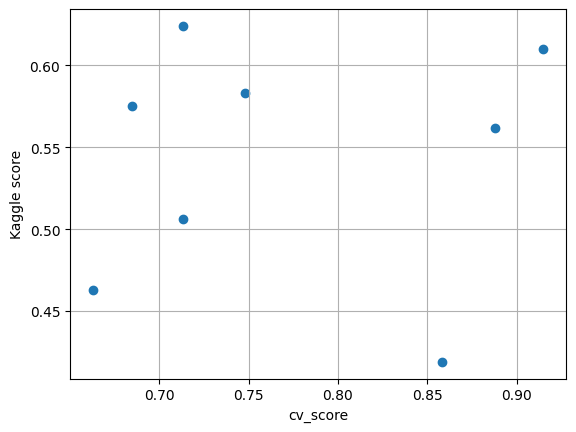

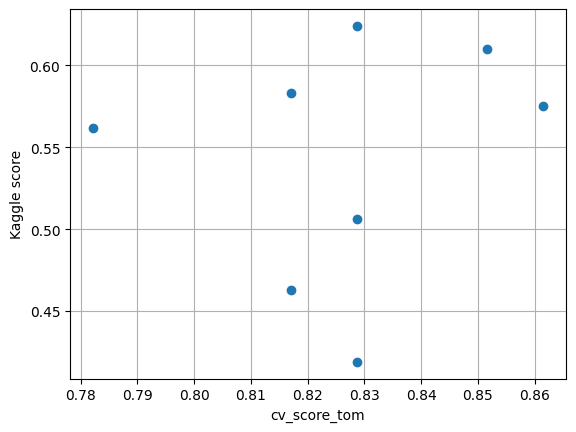

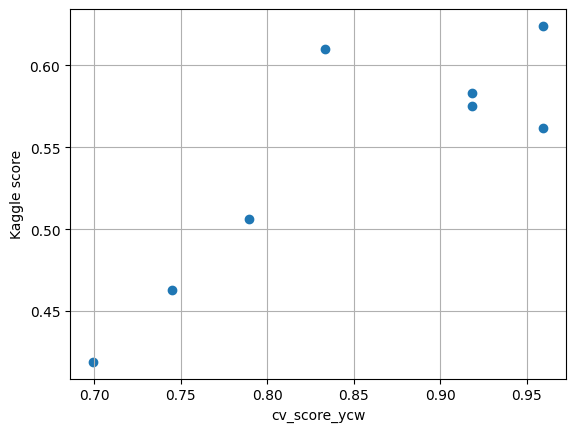

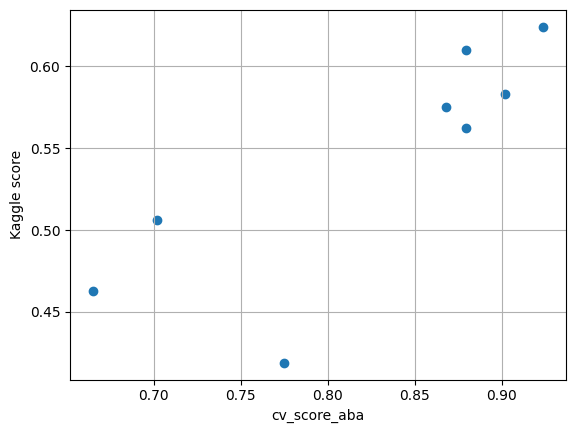

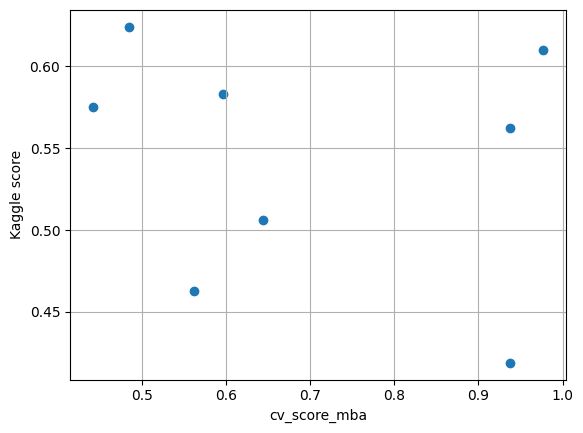

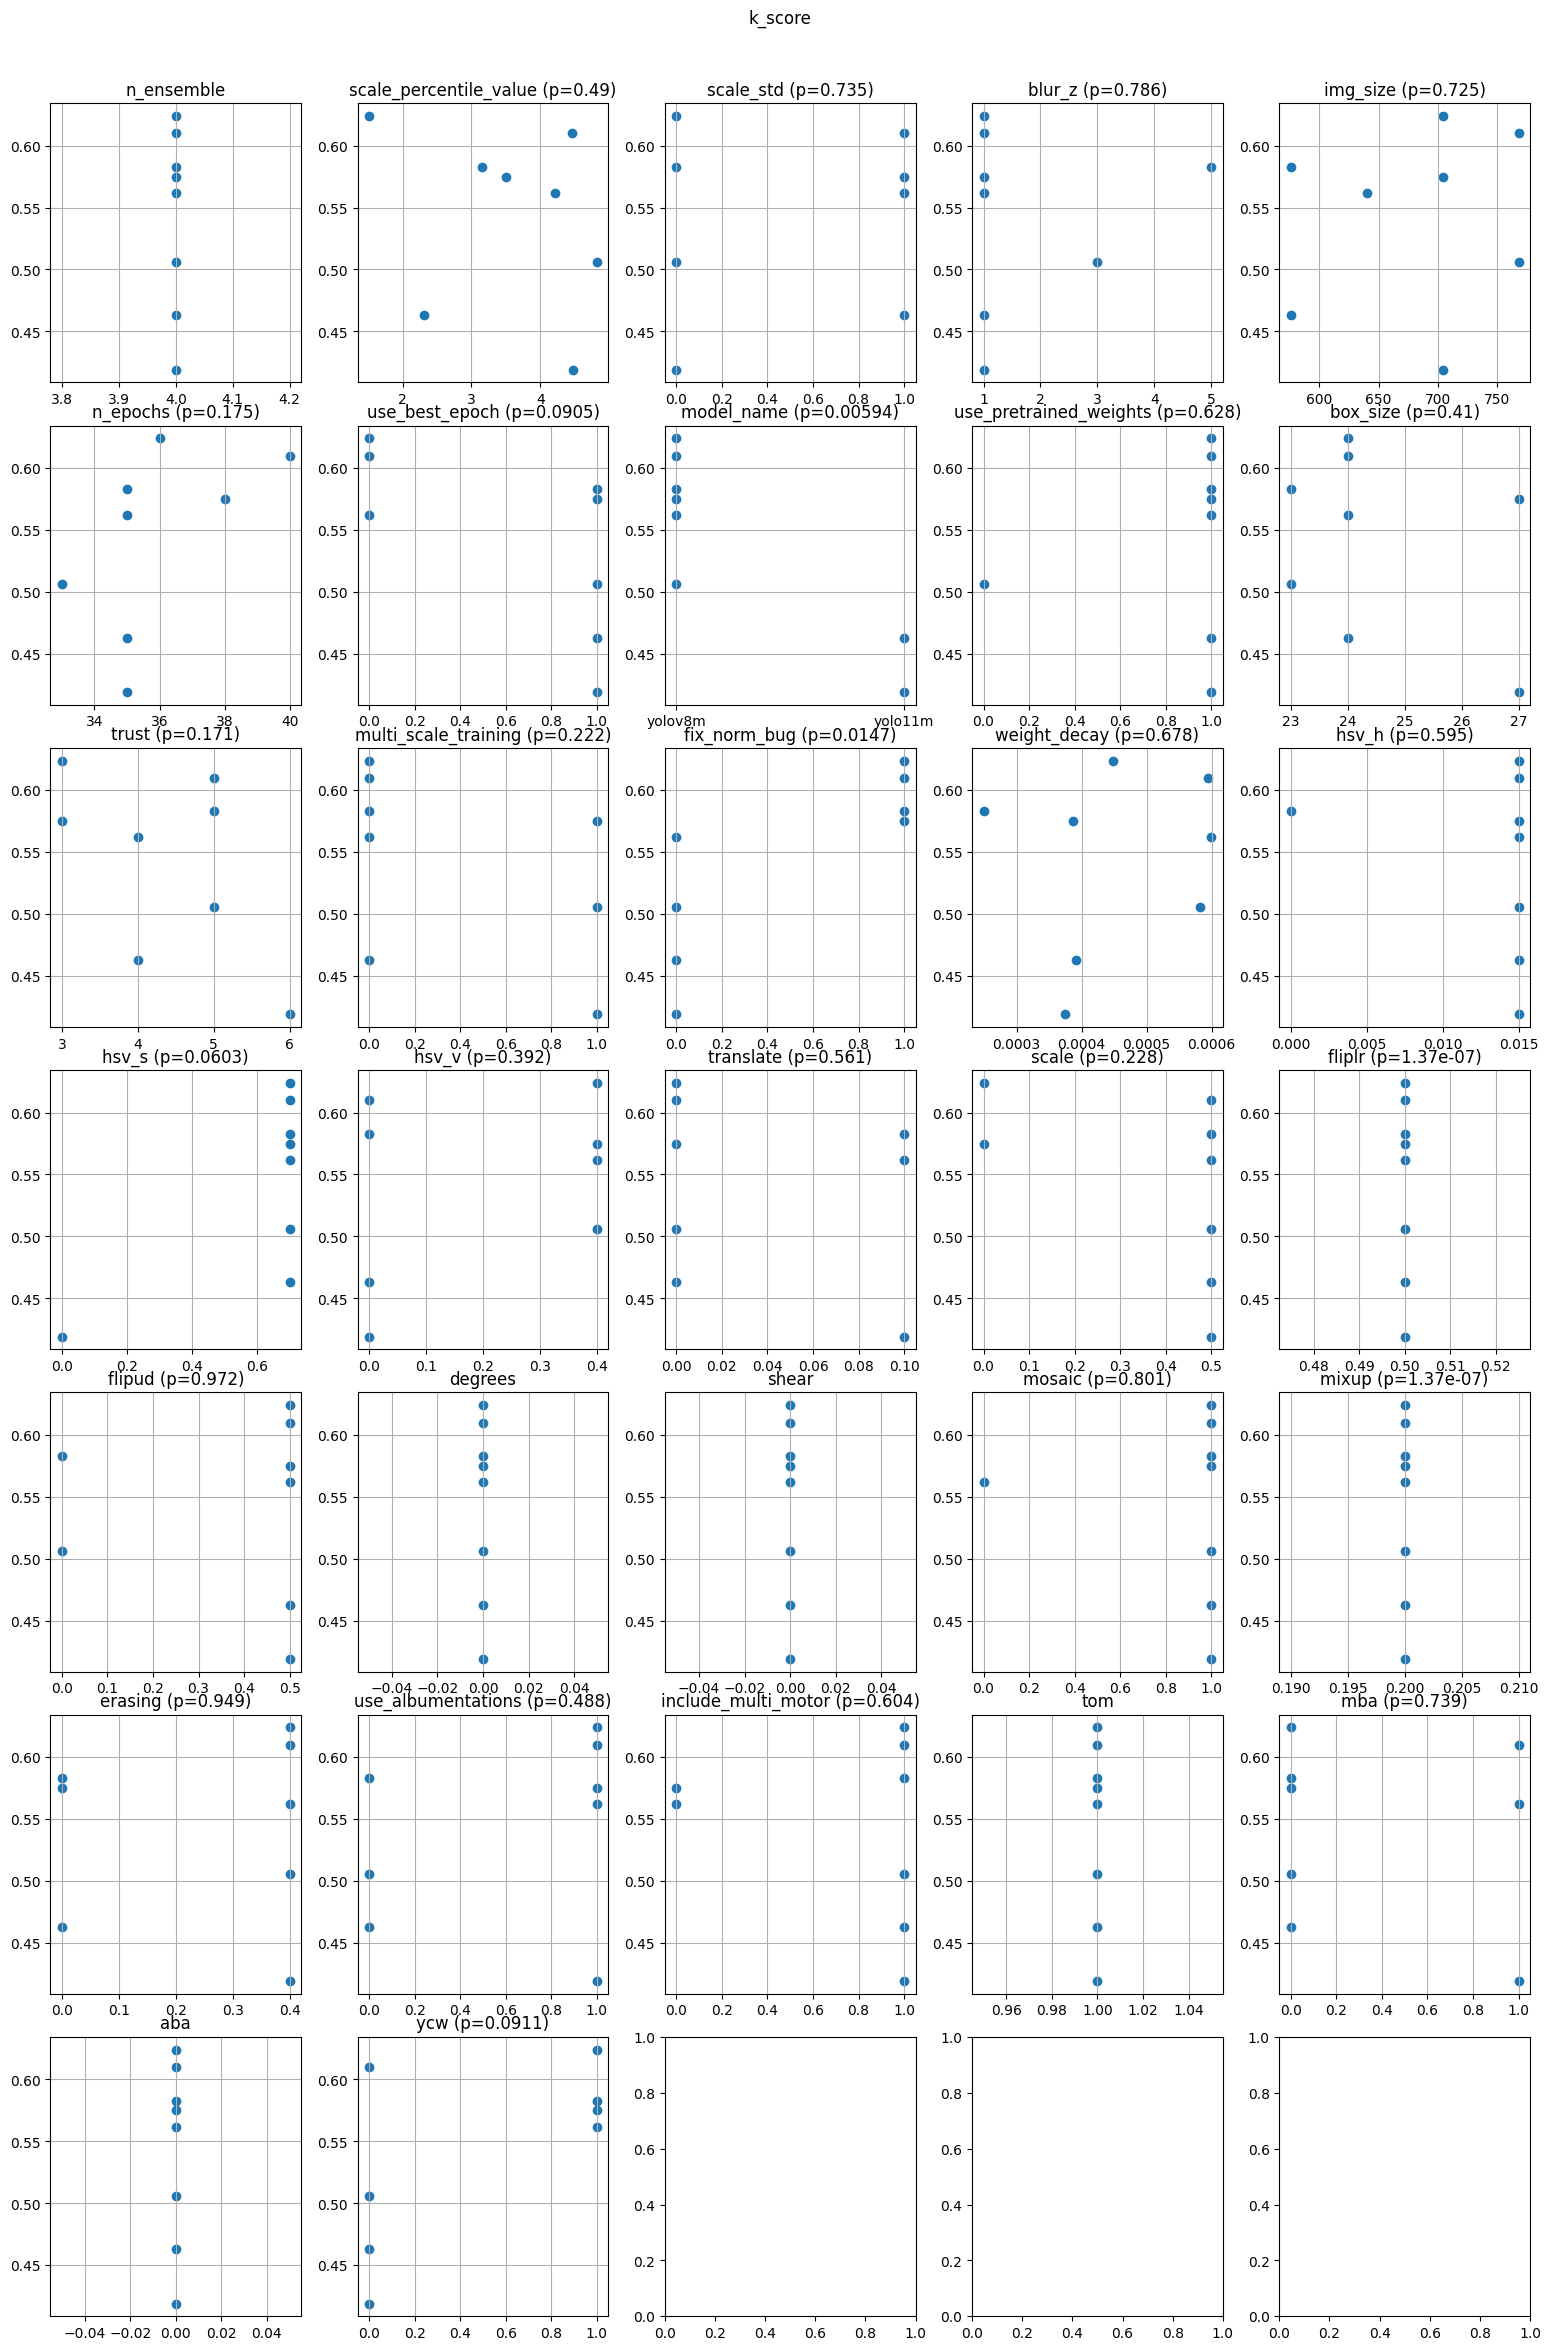

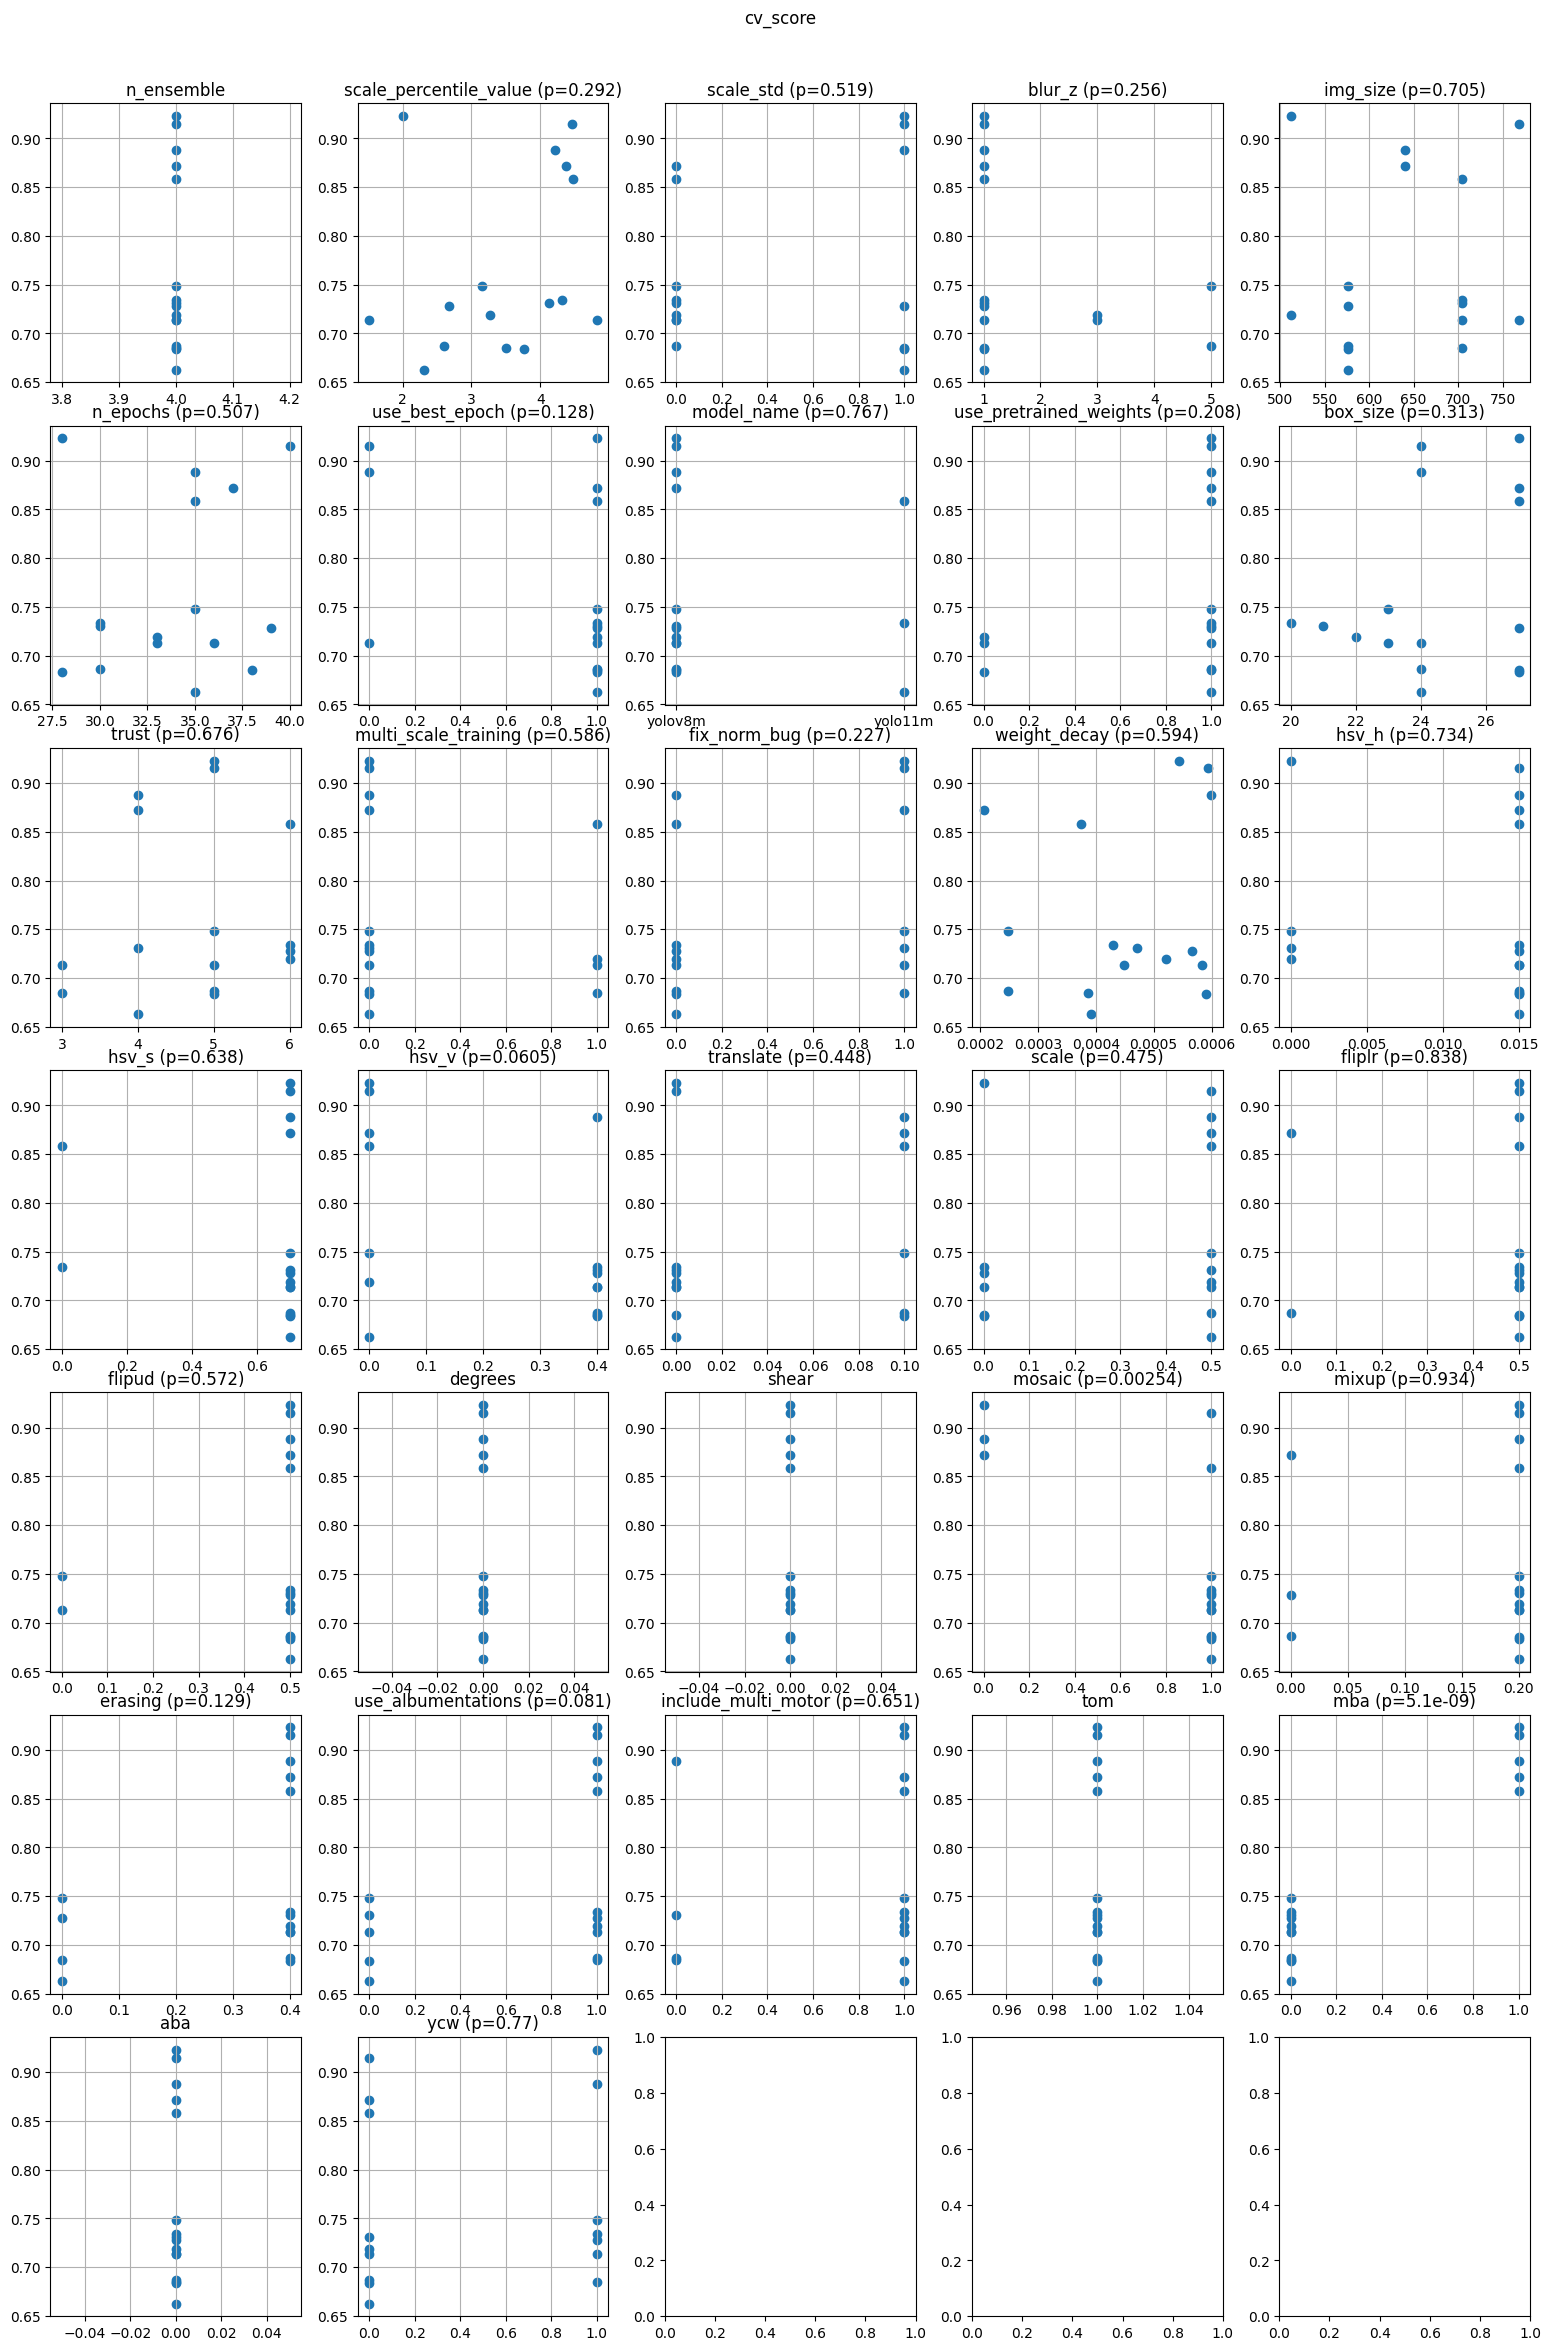

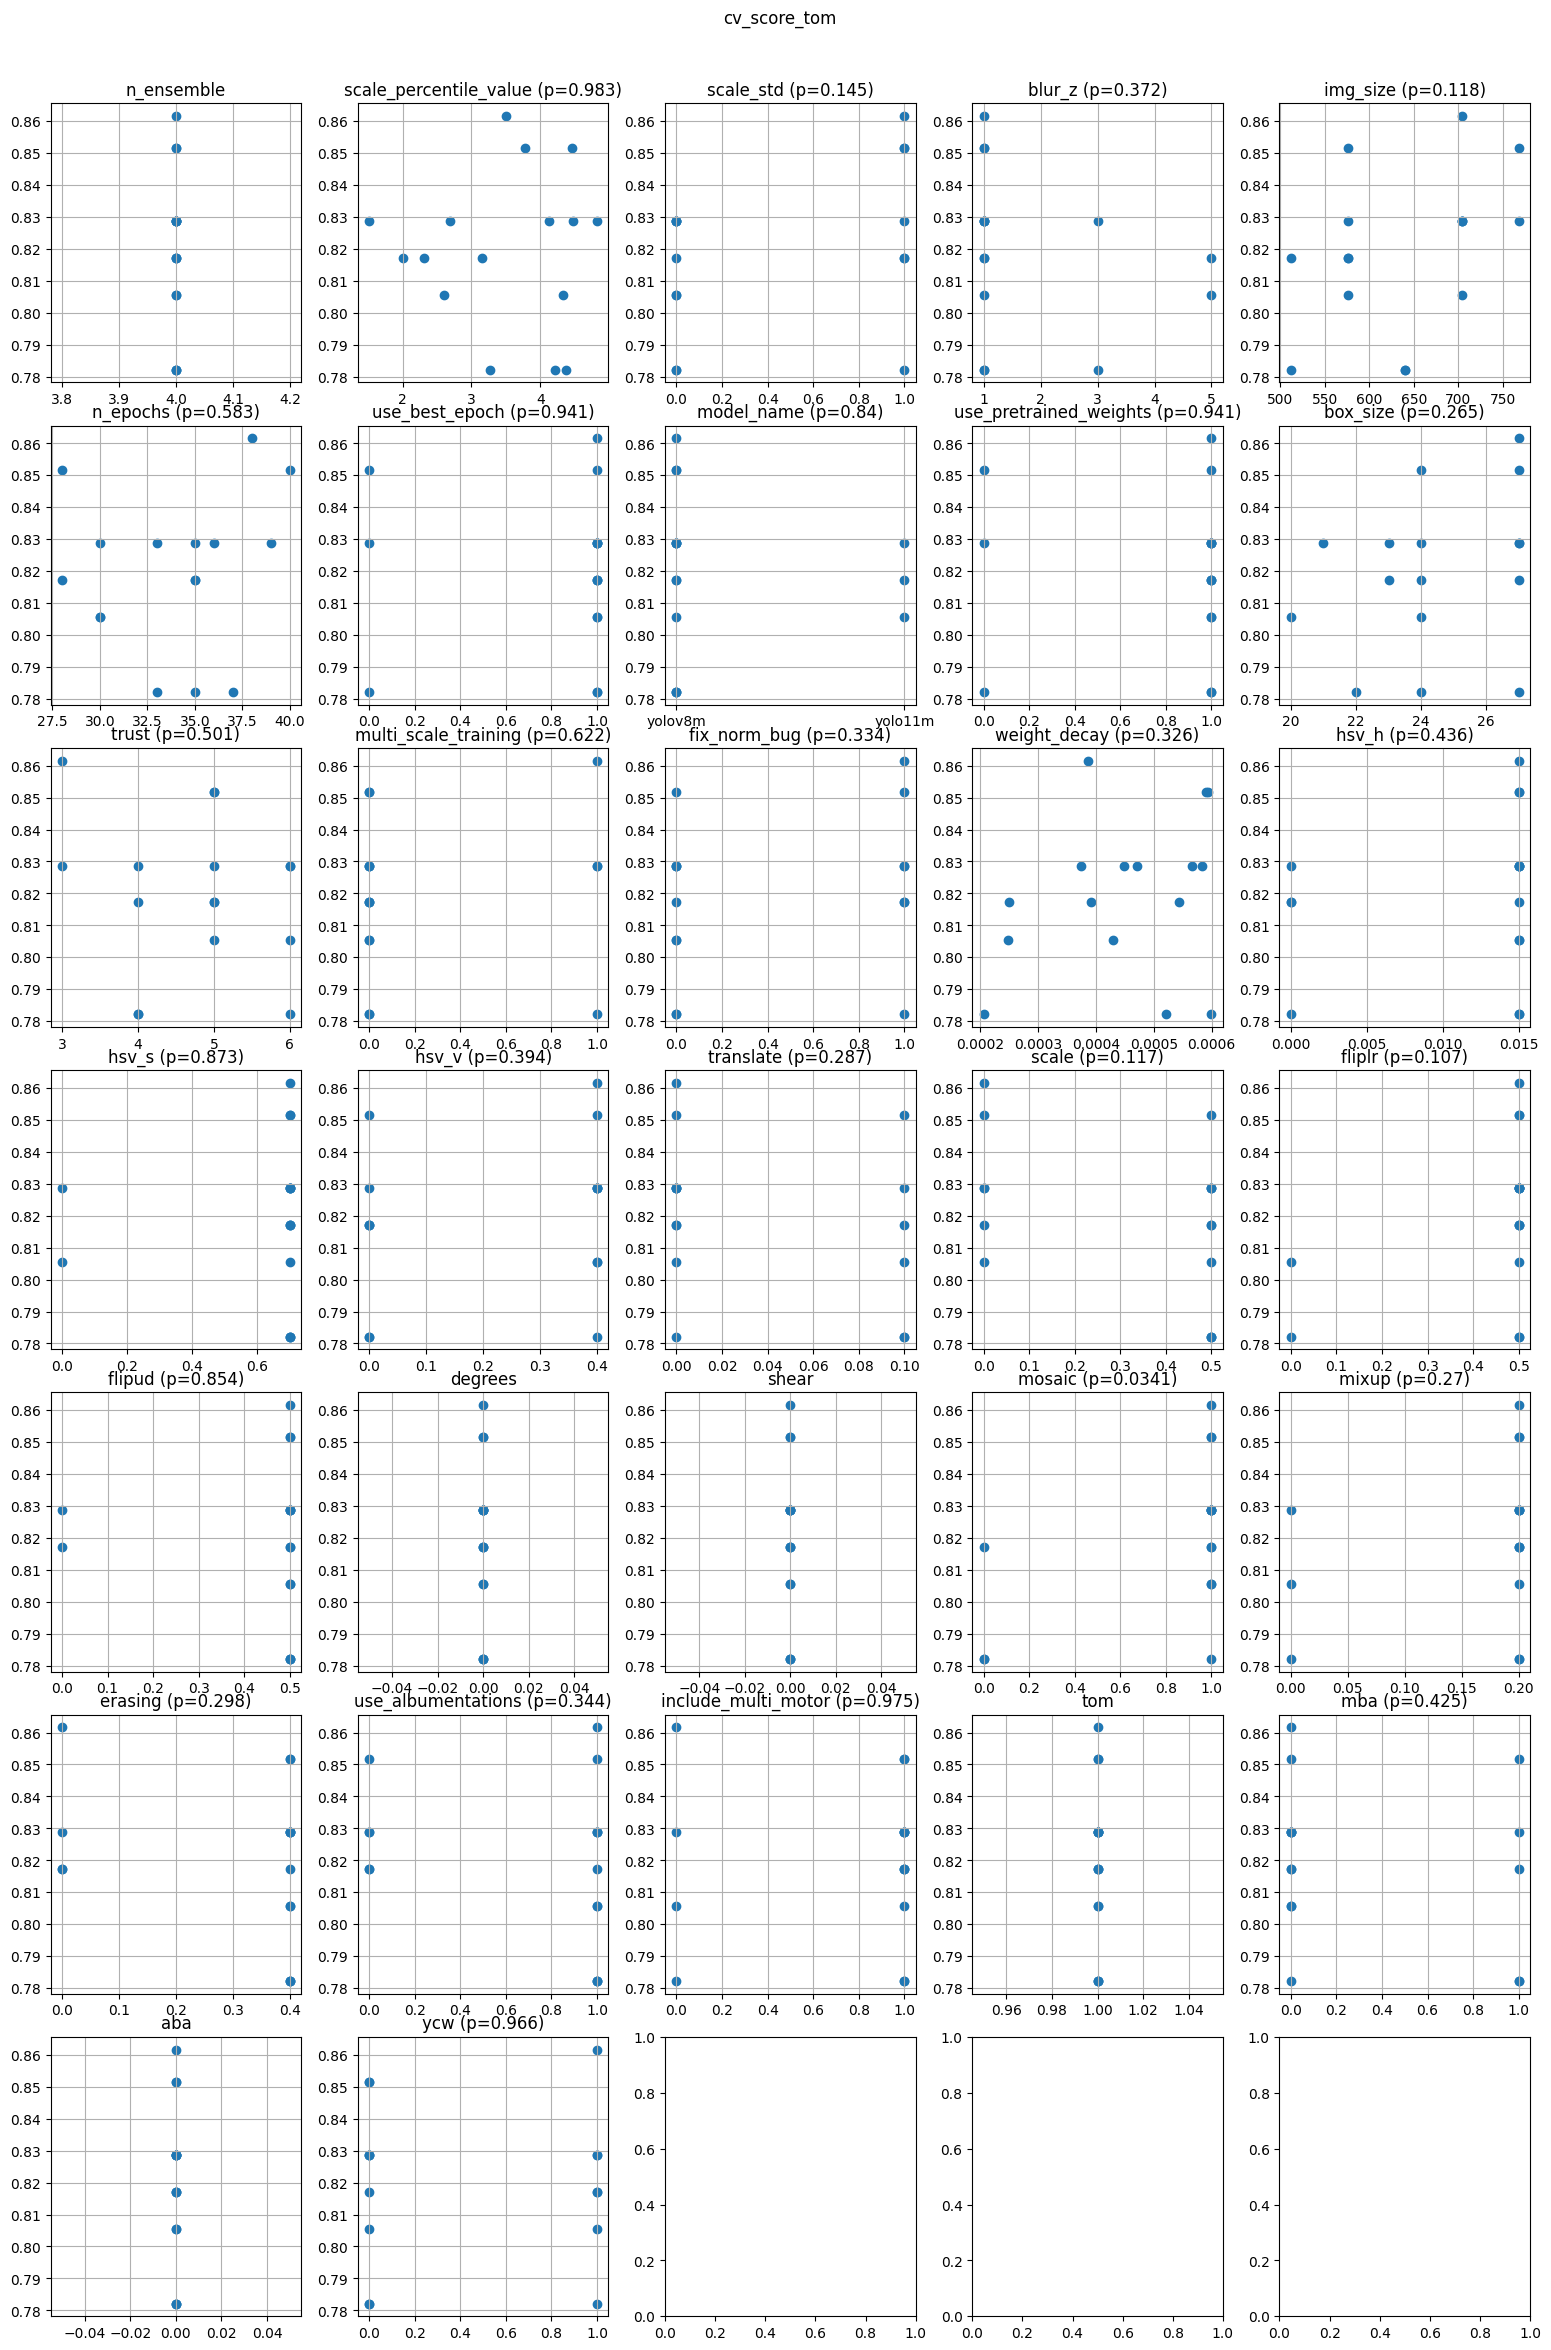

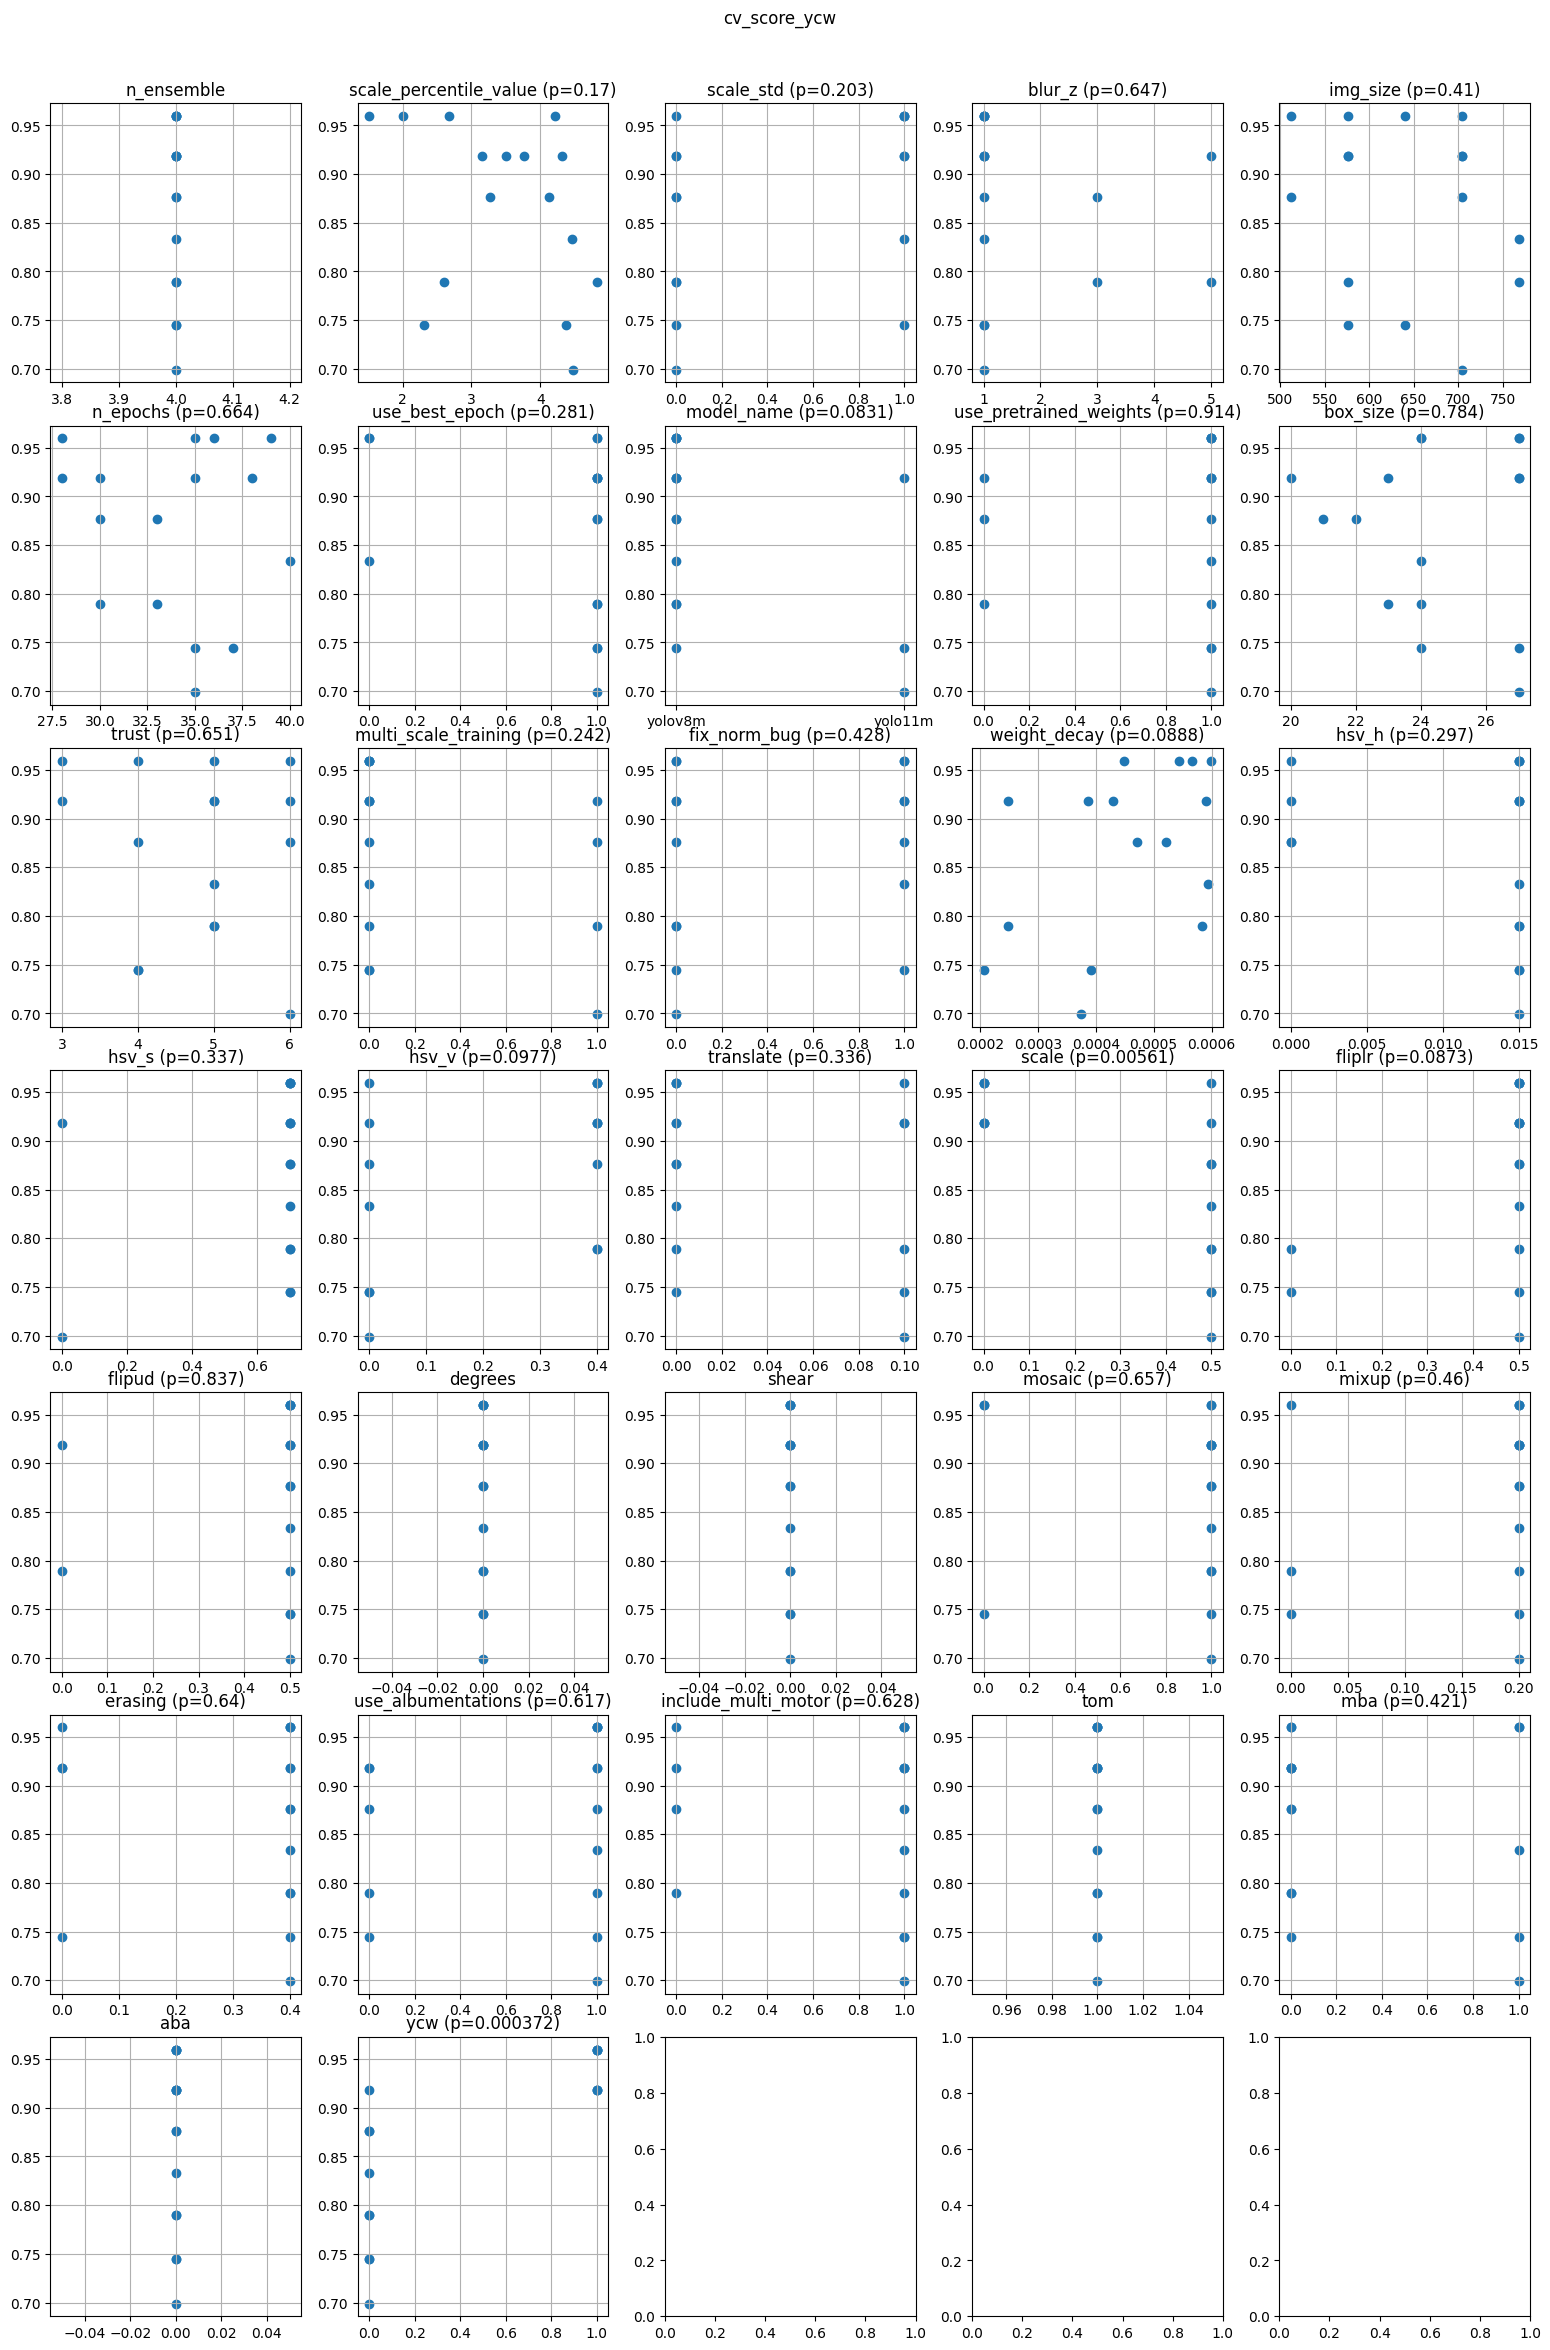

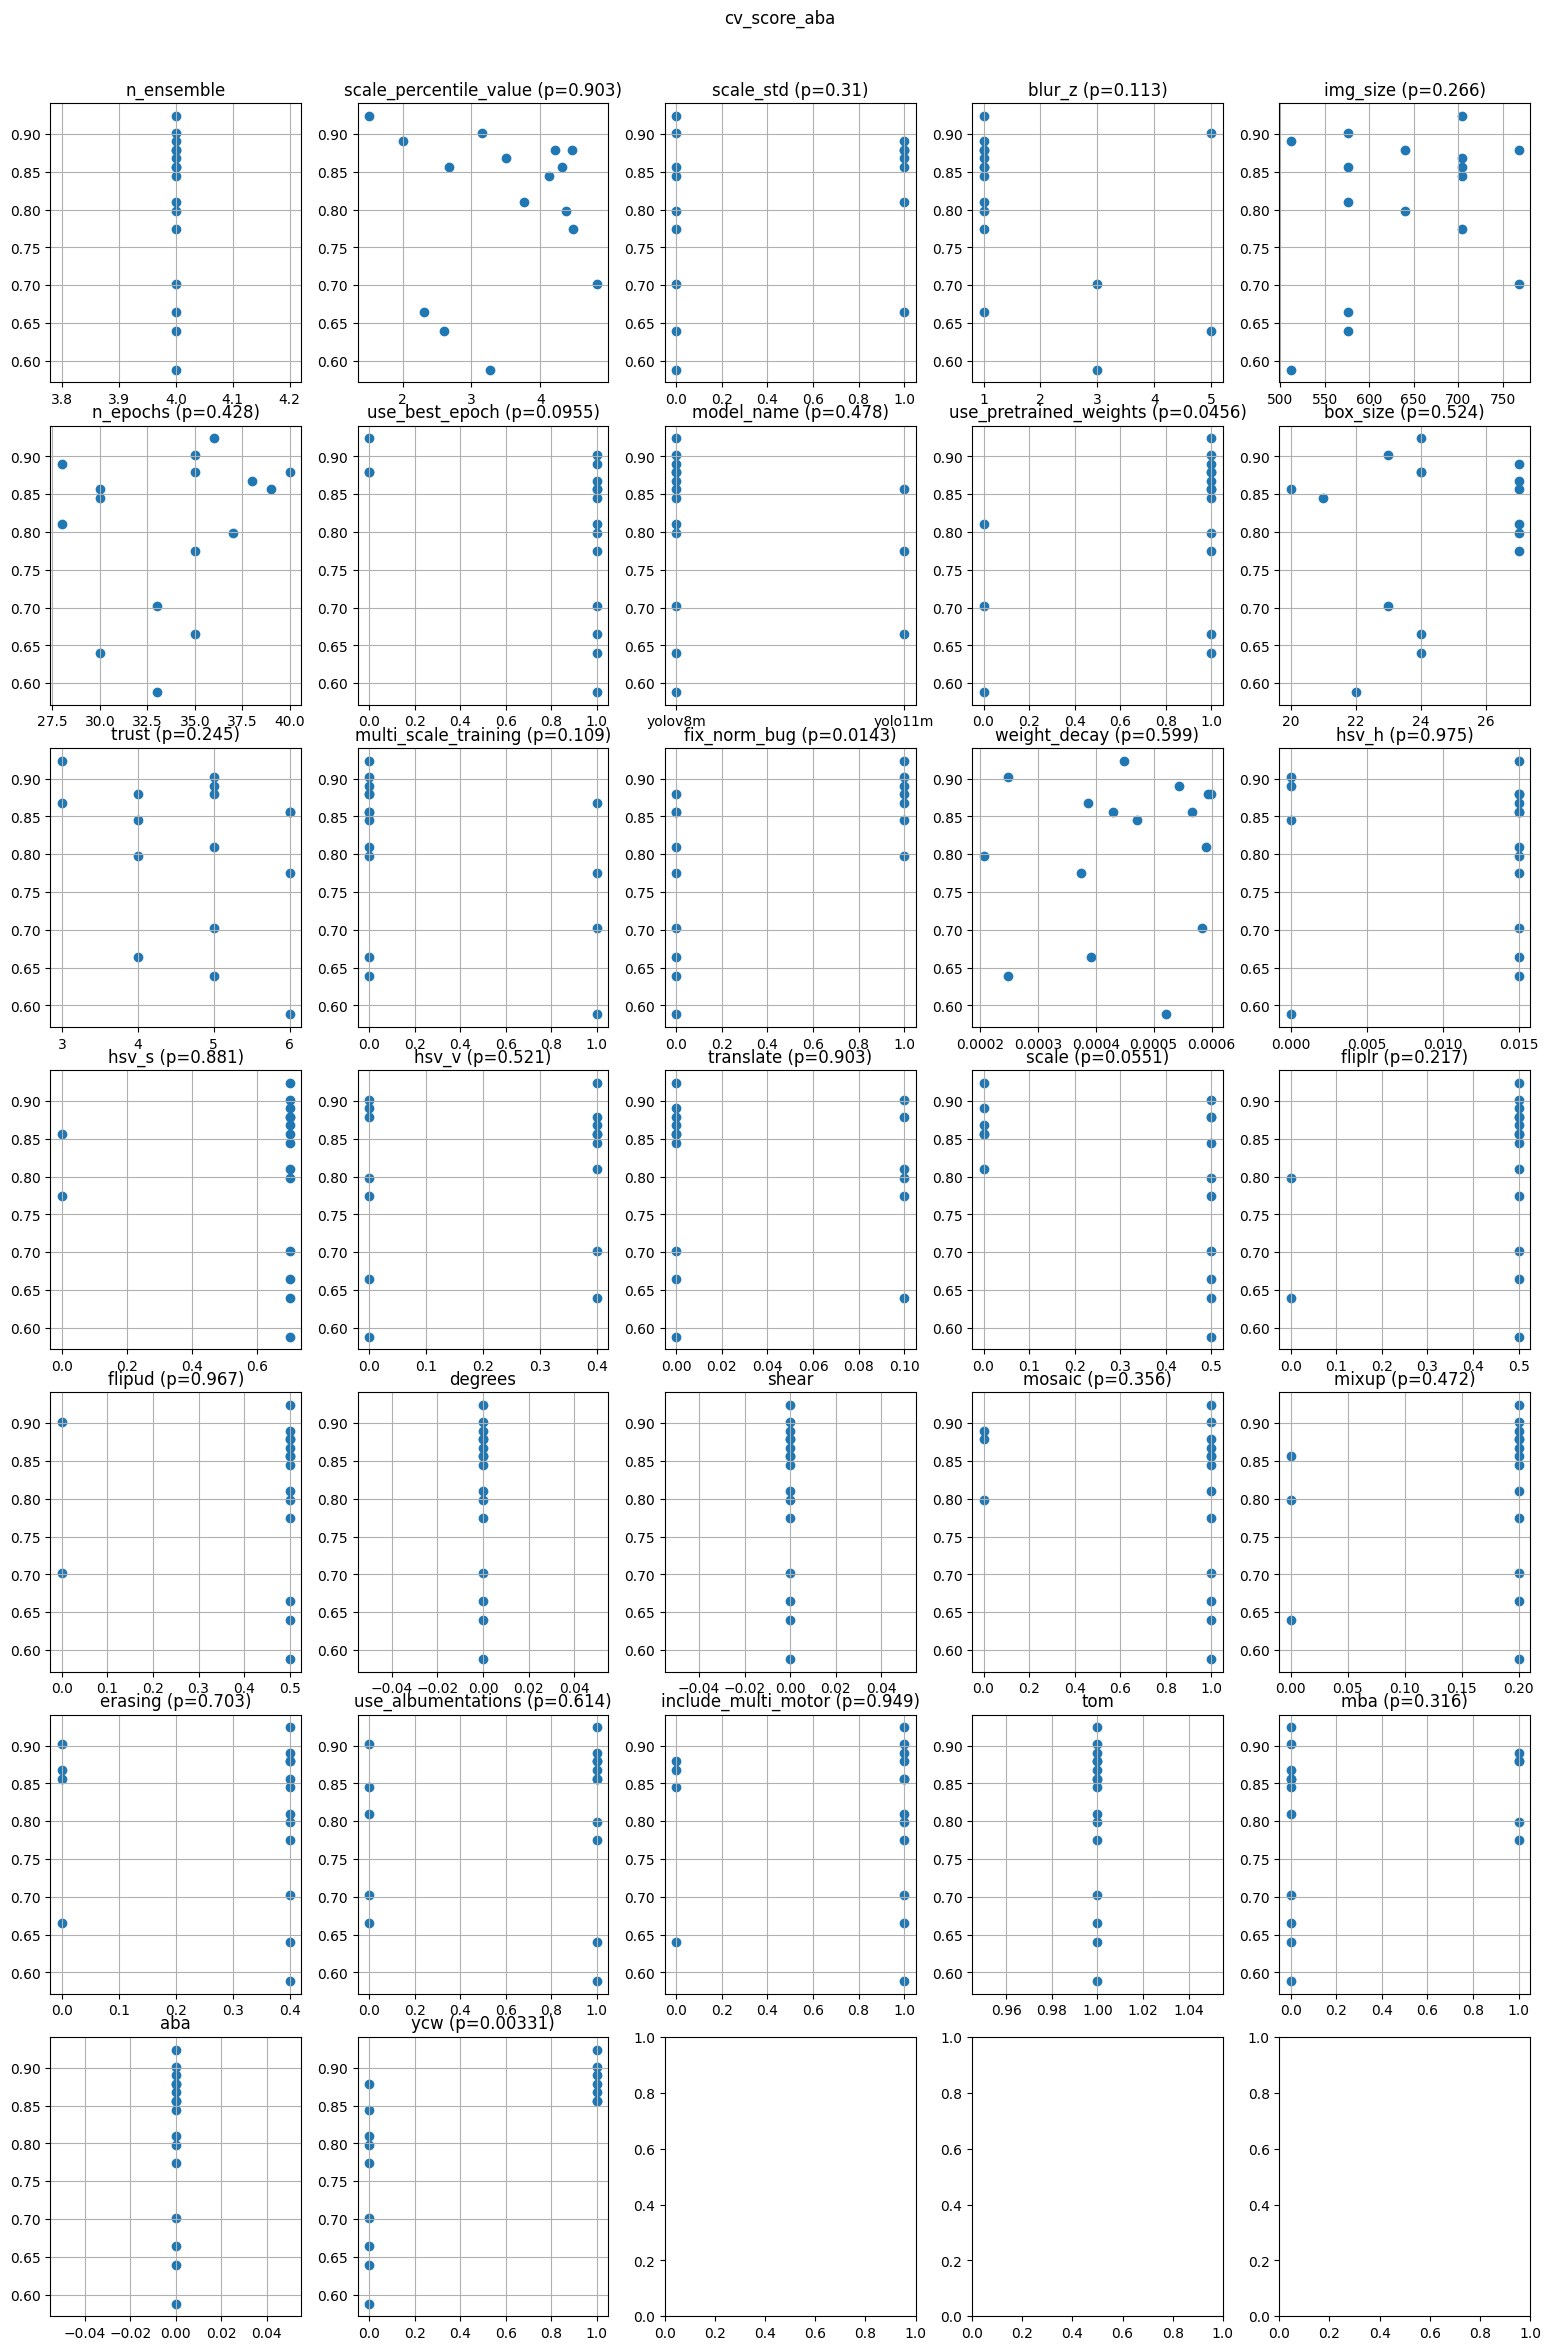

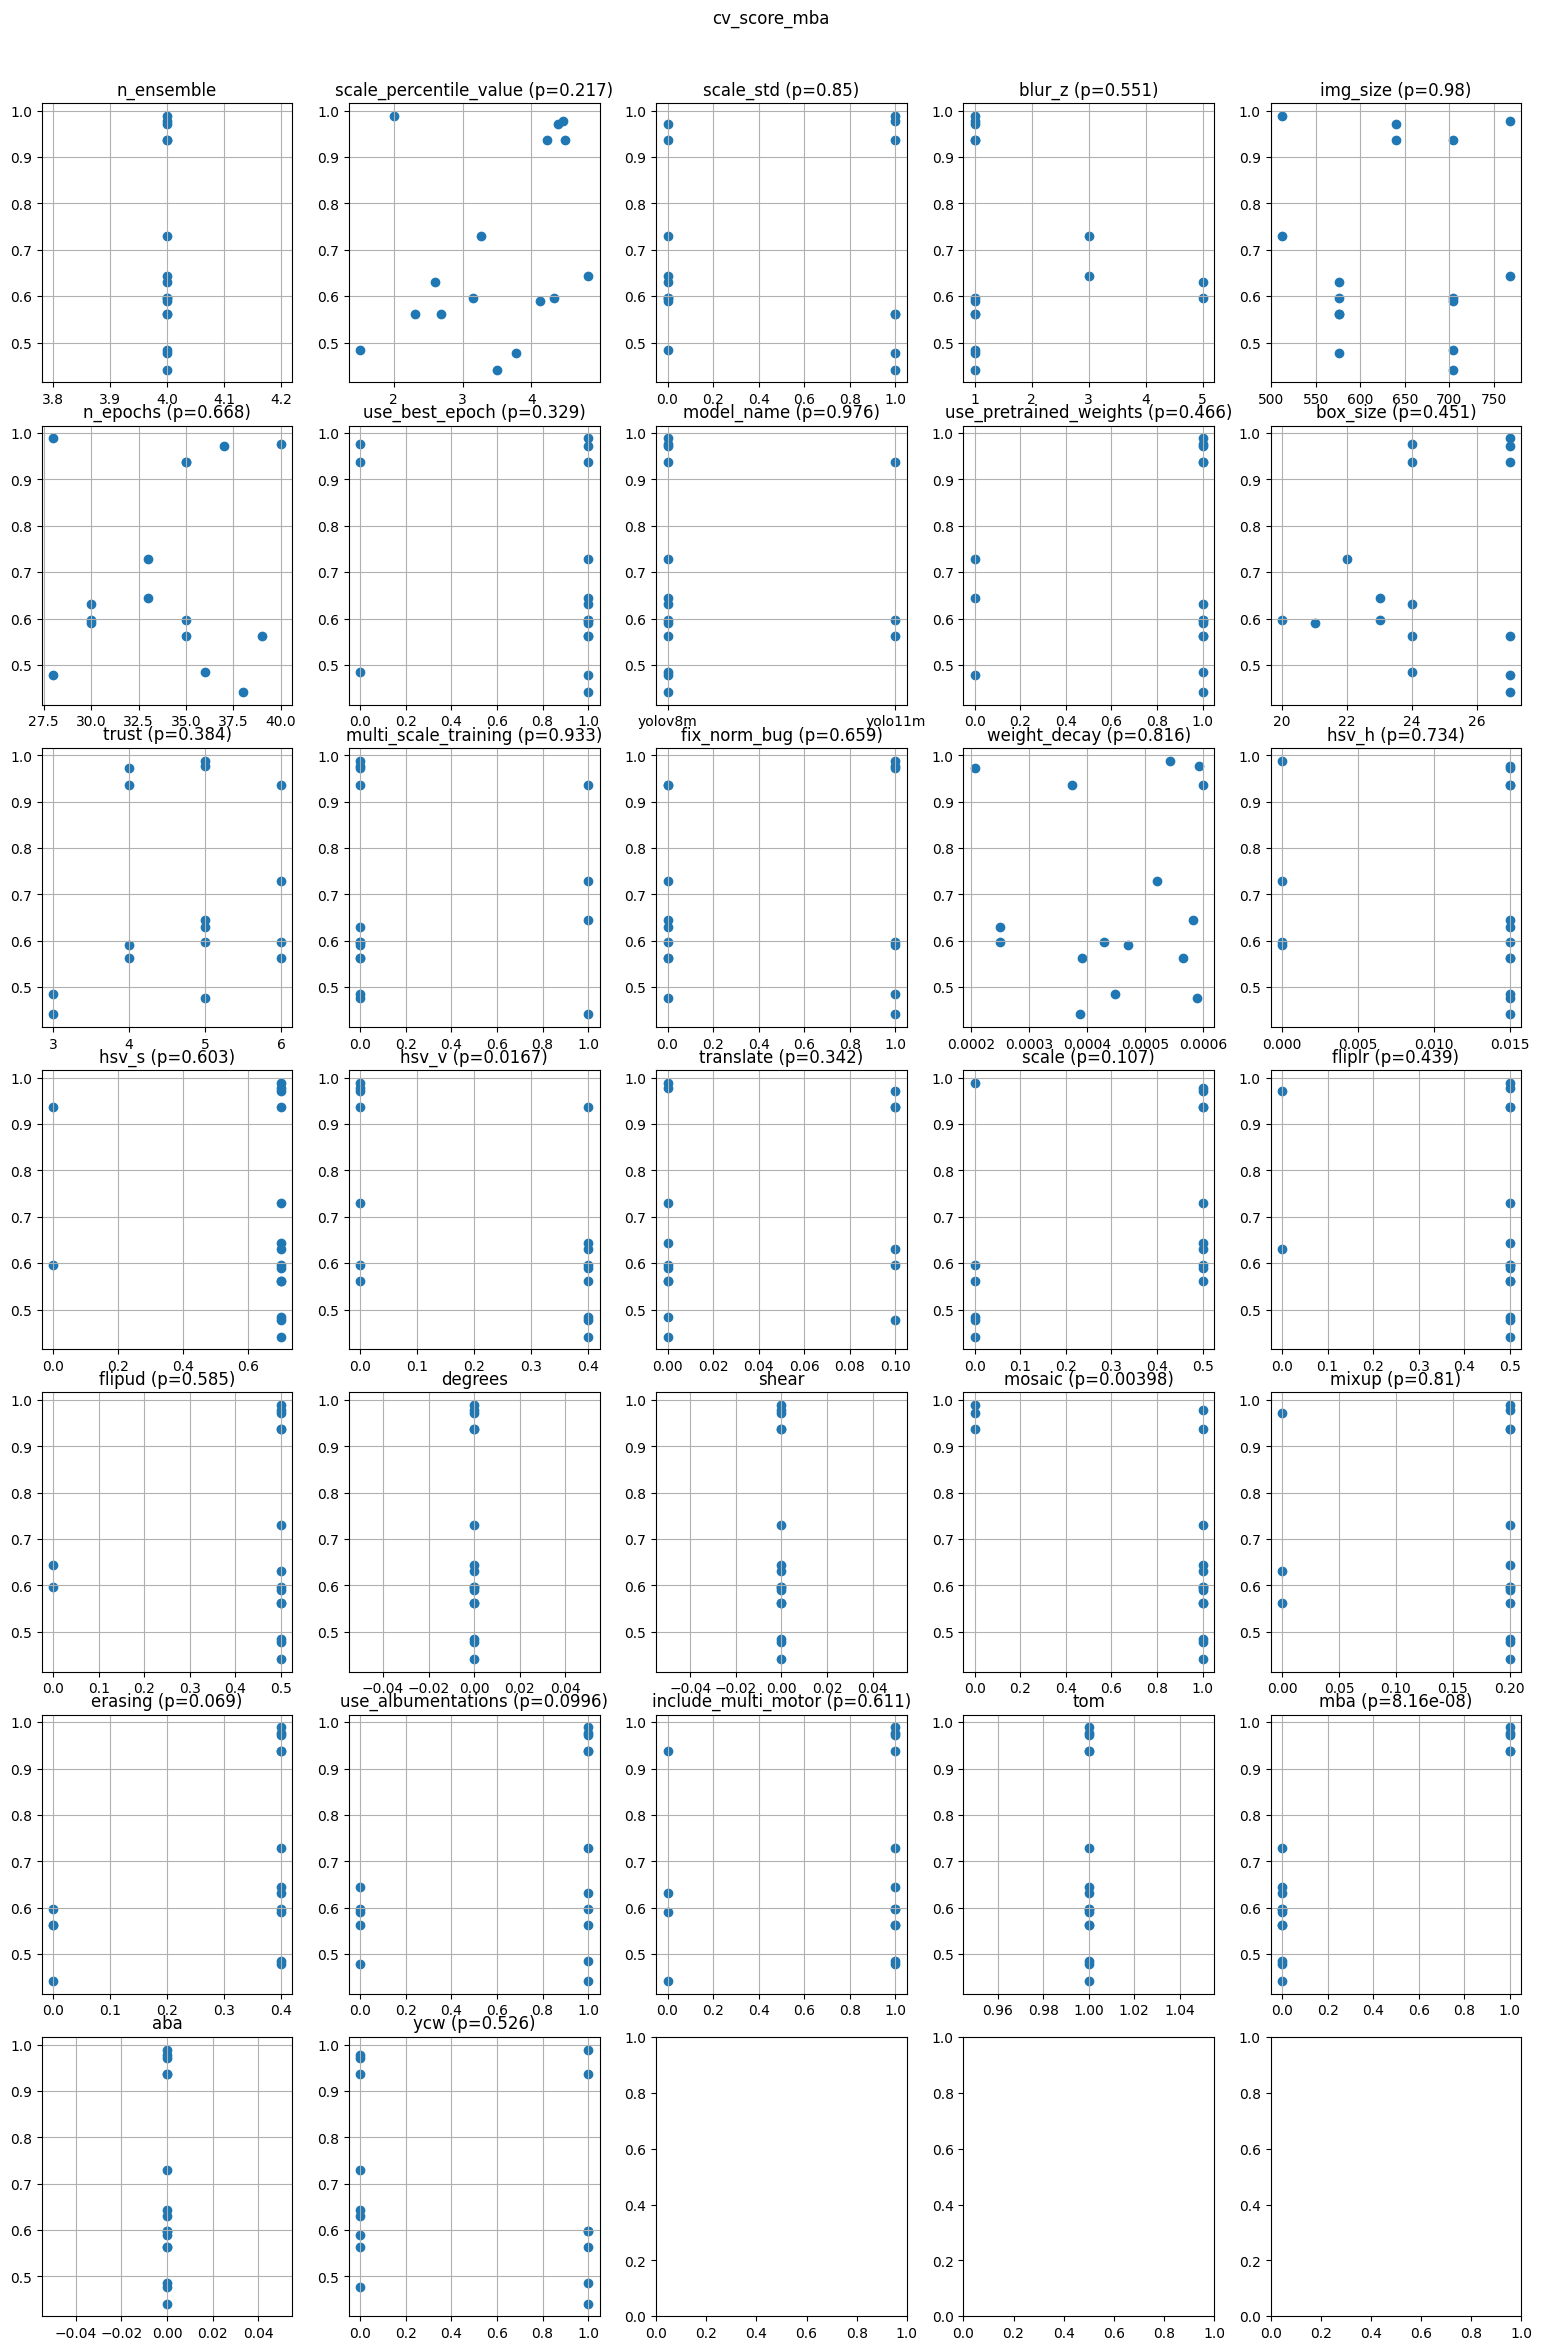

In [21]:
to_plot = copy.deepcopy(p).columns.to_list()[2:-9]
main = np.logical_and(np.logical_not(p['use_missing_value']), np.logical_not(p['cv_score']==0.))
#main = p['tom']
for x_val in ['cv_score', 'cv_score_tom', 'cv_score_ycw', 'cv_score_aba', 'cv_score_mba']:
     plt.figure()
     plt.scatter(p[x_val][main], p['k_score'][main])
     plt.grid(True)
     plt.xlabel(x_val)
     plt.ylabel('Kaggle score')
ncols = 5
nrows = len(to_plot)//ncols+1
figs = []
for y_val in p.columns[-6:][[5,0,1,2,3,4]].to_list():
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18/ncols*nrows))
    plt.tight_layout(pad=10.0,h_pad=1,w_pad=1)
    figs.append(fig)
    plt.suptitle(y_val)
    for idx,d in enumerate(to_plot):
        row = idx // ncols
        col = idx % ncols
        ax = axes[row, col]
        plt.sca(ax)        
        plt.xlabel('')
        plt.ylabel('')
        plt.grid(True)
        plt.scatter(p[d][main], p[y_val][main])
        #plt.scatter(p[d][np.logical_not(main)], p[y_val][np.logical_not(main)])
       
        # fit
        if len(np.unique(p[d][main]))>1:
            pp = copy.deepcopy(p)
            if not pd.api.types.is_numeric_dtype(pp[d]) or pd.api.types.is_bool_dtype(pp[d]):
                pp[d] = pp[d].astype('category').cat.codes
            X = pp[[d]][main]
            X['intercept'] = 1.
            y = p[y_val][main]
            to_keep = np.logical_not(np.isnan(y))
            X = X[to_keep]; y=y[to_keep];
            model = sm.OLS(y,X)
            results=model.fit()
            p_val = results.pvalues[d]
            plt.title(f'{d} (p={p_val:.3})')
        else:
            plt.title(d)
        
        # if d == 'mask_sizes0':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][0] for m in model_list]
        # elif d == 'mask_sizes1':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][1] for m in model_list]
        # elif d == 'mask_sizes2':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][2] for m in model_list]
        # else:
        #     x_vals = [getattr(m, d)[model.particles_to_do[0]] for m in model_list]
        # if len(np.unique(x_vals))<8:
        #     #pass
        #     violin_plot(x_vals,score_vals)
        # else:
        #     plt.scatter(x_vals, score_vals)

In [10]:
from pptx import Presentation
from pptx.util import Inches

prs = Presentation()
blank = prs.slide_layouts[6]  # a blank slide layout

for i, fig in enumerate(figs):
    # save each figure to disk
    img_path = f"figure_{i+1}.png"
    fig.savefig(img_path, dpi=300, bbox_inches='tight')

    # add a new slide, then add the image to it
    slide = prs.slides.add_slide(blank)
    slide.shapes.add_picture(
        img_path,
        Inches(1), Inches(1),          # left, top margins
        width=Inches(8)                # scale width (height auto)
    )

    os.remove(img_path)

prs.save("run_many_models_results.pptx")